In [1]:
%pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate

In [3]:
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


### prepare data for finetuning

In [4]:
url = 'https://www.dropbox.com/scl/fi/i2esmtinb4qor0mzokybp/fed_sentiment_training.csv?rlkey=v9u7afunmy8w0v0lwizba5g25&dl=1'
df = pd.read_csv(url, sep='\t')
df.head()

,ID,text,sentiment
0,157_1,The action was taken to cushion the effects on...,dovish
1,161_2,Such trends could foster inflationary imbalanc...,hawkish
2,52_0,The Federal Open Market Committee at its meeti...,neutral
3,21_5,Although continuing favorable trends bolster l...,dovish
4,78_7,The Committee perceives that the upside and do...,neutral


In [5]:
# perform train-test split

n = len(df)
test_size = int(0.1 * n)
indices = np.random.RandomState(95).permutation(n)
train_idxs, test_idxs = indices[test_size:], indices[:test_size]

In [6]:
train_idxs

array([759, 439, 548, ..., 343, 773, 118])

In [7]:
test_idxs

array([1089,  557,  552,  630,  464,  777,  700, 1238,  842,  667, 1064,
        509,  730,  738,  340,  749,  458,  838,  392,  922,  621,  610,
       1199,  812, 1152,  157,  575,  714,  409,  553,  393, 1132,  734,
        300,  944,  228,  495,  215,  530,  432,  420,  168,  177,  645,
        100,  191, 1195, 1066, 1191,  396,   58,  367,  224,   77, 1027,
       1159,  371, 1048,  867,  257,  614,  781,  502,  161,  453,  668,
        342, 1211, 1172,  883,   87,  308, 1144,  782, 1116,  535, 1096,
       1216, 1173, 1200, 1164, 1236,  979,  592,  299,  713,  722,  286,
       1141,    9, 1231,  317,  445,  428,  638,  795,  404,  913,  363,
       1053,  674,  992,  808,  329,  769,  174,  327, 1068,  375,  721,
        262,   73,  278,  417,  143,  309, 1205,  488,   66, 1168, 1128,
        307, 1018,  819])

In [8]:
unique_labels = sorted(df['sentiment'].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
print(label2id)

df_finetune = df.iloc[train_idxs][["text", "sentiment"]].copy()
df_finetune['labels'] = df_finetune['sentiment'].map(label2id)
print(df_finetune.shape)

df_test = df.iloc[test_idxs][["text", "sentiment"]].copy()
df_test['labels'] = df_test['sentiment'].map(label2id)
print(df_test.shape)

{'dovish': 0, 'hawkish': 1, 'neutral': 2}
(1119, 3)
(124, 3)


In [9]:
df_finetune.head()

,text,sentiment,labels
759,"Consequently, the Committee believes that, for...",dovish,0
439,"In these circumstances, when the economic situ...",neutral,2
548,The Federal Reserve will employ all available ...,dovish,0
657,"Moreover, strains in financial markets have in...",dovish,0
986,"Tight credit conditions, the ongoing housing c...",dovish,0


### use hugging face for finetuning

In [10]:
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
# tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=512, padding="max_length", truncation=True)


# batched=True is key for training
tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1119 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

In [13]:
tokenized_ft

Dataset({
    features: ['text', 'sentiment', 'labels', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1119
})

In [19]:
pd.DataFrame(tokenized_ft[:5])

,text,sentiment,labels,__index_level_0__,input_ids,token_type_ids,attention_mask
0,"Consequently, the Committee believes that, for...",dovish,0,759,"[101, 8821, 1010, 1996, 2837, 7164, 2008, 1010...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"In these circumstances, when the economic situ...",neutral,2,439,"[101, 1999, 2122, 6214, 1010, 2043, 1996, 3171...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,The Federal Reserve will employ all available ...,dovish,0,548,"[101, 1996, 2976, 3914, 2097, 12666, 2035, 280...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"Moreover, strains in financial markets have in...",dovish,0,657,"[101, 9308, 1010, 18859, 1999, 3361, 6089, 203...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
4,"Tight credit conditions, the ongoing housing c...",dovish,0,986,"[101, 4389, 4923, 3785, 1010, 1996, 7552, 3847...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [14]:
model_ft = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(label2id),
    label2id=label2id,
    id2label={idx: label for label, idx in label2id.items()}
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir="./output",          # path to save model
    learning_rate=5e-5,             # small learning rates
    num_train_epochs=2,             # number of finetuning passes
    per_device_train_batch_size=8,  # batch size per GPU
    per_device_eval_batch_size=8,   # batch size per GPU
    eval_strategy="epoch",          # See metrics during training
    save_strategy="no",             # Don't save checkpoints
    report_to="none",               # Don't report model estimation externally
)

In [20]:
# model performance metrics

metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
metric_f1 = evaluate.load("f1")
metric_accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision = metric_precision.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric_recall.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}

In [21]:
print(f"Training samples: {len(tokenized_ft)}")
print(f"Batches per epoch: {len(tokenized_ft) / 8}")

Training samples: 1119
Batches per epoch: 139.875


In [22]:
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.613775,0.774194,0.774194,0.774194,0.774194
2,No log,0.565922,0.814516,0.814516,0.814516,0.814516


TrainOutput(global_step=280, training_loss=0.5959282466343471, metrics={'train_runtime': 216.798, 'train_samples_per_second': 10.323, 'train_steps_per_second': 1.292, 'total_flos': 588847828875264.0, 'train_loss': 0.5959282466343471, 'epoch': 2.0})

### evaluate model on test data

In [23]:
# Get predictions
results = trainer.predict(tokenized_test)
predictions = np.argmax(results.predictions, axis=-1)

# Add to dataframe
df_test['prediction'] = predictions

# Map back to text labels for interpretability
id2label = {idx: label for label, idx in label2id.items()}
df_test['predicted_sentiment'] = df_test['prediction'].map(id2label)
df_test['true_sentiment'] = df_test['labels'].map(id2label)

df_test.head()

,text,sentiment,labels,prediction,predicted_sentiment,true_sentiment
1089,Higher energy and other costs have the potenti...,hawkish,1,1,hawkish,hawkish
557,The Committee will continue to monitor the eco...,neutral,2,0,dovish,neutral
552,The Committee perceives the upside and downsid...,neutral,2,2,neutral,neutral
630,The Committee expects inflation to moderate la...,hawkish,1,2,neutral,hawkish
464,Information received since the Federal Open Ma...,dovish,0,0,dovish,dovish


In [24]:
# Show mistakes
print("\nMisclassified examples:")
mistakes = df_test[df_test['labels'] != df_test['prediction']]

first_mistake = mistakes.iloc[0]
print(f"Text: {first_mistake['text']}")
print(f"True: {first_mistake['true_sentiment']}")
print(f"Predicted: {first_mistake['predicted_sentiment']}")

print(f"Accuracy: {1-len(mistakes)/len(df_test)}")



Misclassified examples:
Text: The Committee will continue to monitor the economic outlook and financial developments and will employ its policy tools as necessary to promote economic recovery and price stability
True: neutral
Predicted: dovish
Accuracy: 0.814516129032258


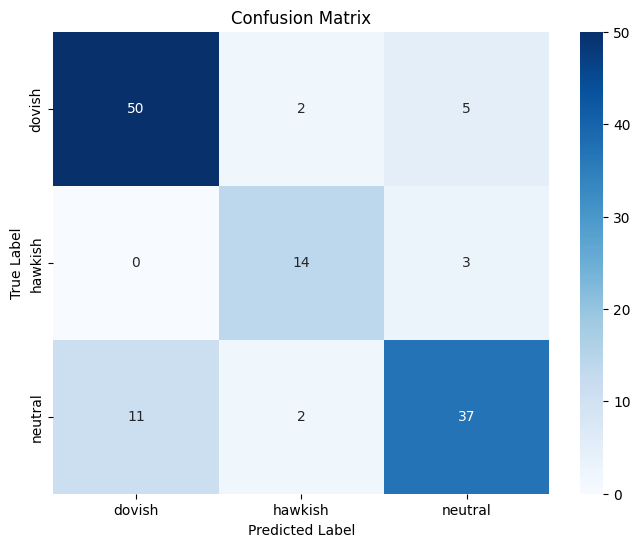

In [25]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df_test['labels'], df_test['prediction'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(label2id.keys()),
            yticklabels=sorted(label2id.keys()))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()